# First Model On Client Train Data-set

# 1. Import Data

All 120 train images are split into 3 smaller 410 $\times$ 410 images and are labeled mannually in to 2 categories: `cracked` and `none` (binary classification).

In [1]:
import pylab, random, os, math, sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# To cancel scientific notation
np.set_printoptions(suppress=True)

%matplotlib inline
# %matplotlib tk
%config InlineBackend.figure_format = 'retina'

# To set plotting style
plt.style.use("classic")
plt.style.use("bmh")
plt.style.use("seaborn-whitegrid")

# To hide warnings
import warnings
warnings.filterwarnings("ignore")

Load all labels:

In [2]:
PATH = "/Users/ray/Desktop/crack-images/LCMS-Range-Labeled/reindexed"
labels = pd.read_csv(os.path.join(PATH, "save/labels.csv"), index_col="image_name")
labels

,crack_1,crack_2,crack_3
image_name,,,
00001.JPG,cracked,none,none
00002.JPG,cracked,none,none
00003.JPG,cracked,cracked,cracked
00004.JPG,cracked,cracked,none
00005.JPG,cracked,cracked,none
...,...,...,...
00116.JPG,cracked,cracked,none
00117.JPG,none,none,cracked
00118.JPG,cracked,cracked,cracked


Flatten this dataframe into 1 column:

In [3]:
labels_flatten = {'crack_type' : labels.values.reshape(-1,)}
labels_flatten = pd.DataFrame(labels_flatten, index=np.repeat(labels.index, len(labels.columns)))
labels_flatten["crack_type"] = labels_flatten["crack_type"].map({"cracked": 1, "none": 0})
labels_flatten

,crack_type
image_name,
00001.JPG,1
00001.JPG,0
00001.JPG,0
00002.JPG,1
00002.JPG,0
...,...
00119.JPG,0
00119.JPG,0
00120.JPG,1


Distribution of these labels:

In [4]:
labels_flatten["crack_type"].value_counts()

1    227
0    133
Name: crack_type, dtype: int64

Crack proportion:

In [5]:
(labels_flatten["crack_type"] == 1).sum() / labels_flatten.shape[0]

0.6305555555555555

Load all images into a list:

In [6]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

def load_image(path, color_mode="grayscale"):
    image_list = sorted([file for file in os.listdir(path) if file.endswith("JPG")])
    images = [img_to_array(load_img(os.path.join(path, img))).astype(int) for img in image_list]
    return images, image_list

images,image_list = load_image(PATH)
images[0].shape

(1250, 520, 3)

In [7]:
len(images)

120

In [8]:
image_list[:5]

['00001.JPG', '00002.JPG', '00003.JPG', '00004.JPG', '00005.JPG']

Crop all original images:

In [9]:
ideal_shape = (1230, 410, 3)
crop_bound = {
    "xmin": int((images[0].shape[1] - ideal_shape[1]) / 2),
    "xmax": int((images[0].shape[1] + ideal_shape[1]) / 2 - 1),
    "ymin": int((images[0].shape[0] - ideal_shape[0]) / 2),
    "ymax": int((images[0].shape[0] + ideal_shape[0]) / 2 -1)
}

images_cropped = [img[crop_bound["ymin"]:crop_bound["ymax"] + 1, crop_bound["xmin"]:crop_bound["xmax"] + 1] for img in images]

images_cropped[0].shape

(1230, 410, 3)

Split all images into a list of 3:


In [10]:
y_space = np.linspace(0, ideal_shape[0], 4).astype(int)
y_space[-1] += 1

images_split = [[img[y_space[i]:y_space[i + 1],] for i in range(len(y_space) - 1)] for img in images_cropped]
images_split[0][0].shape

(410, 410, 3)

In [11]:
len(images_split[0])

3

Check the split images of `00001.JPG`:

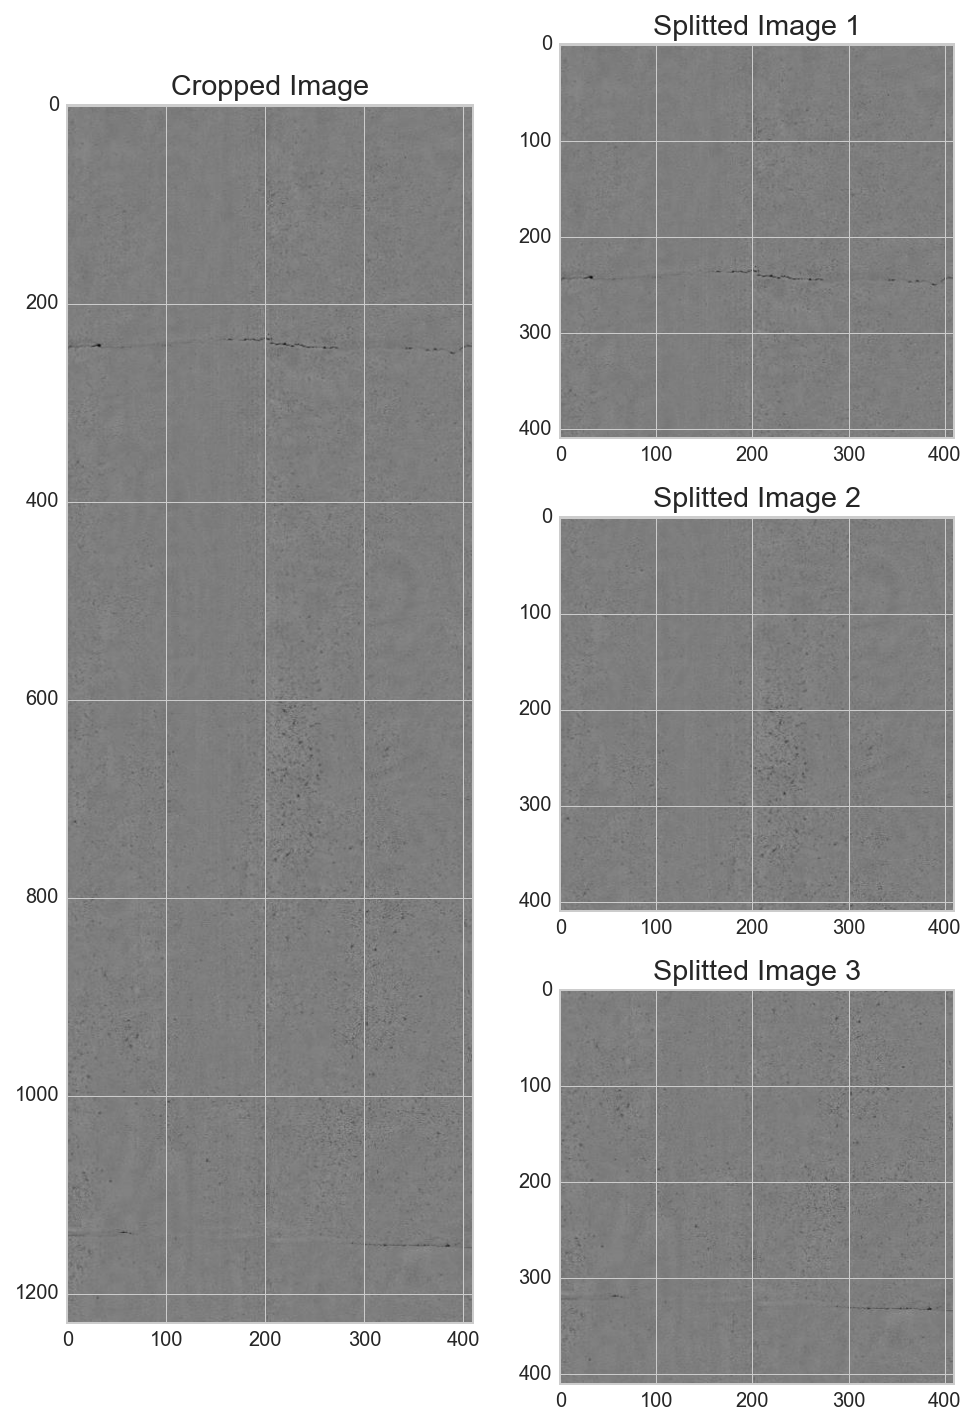

In [12]:
plt.figure(figsize=(8, 12))
plt.subplot(1,2,1)
plt.imshow(images_cropped[0])
plt.title("Cropped Image")
for i in range(1, 4):    
    plt.subplot(3,2,i * 2)
    plt.imshow(images_split[0][i - 1])
    plt.title(f"Splitted Image {i}")
plt.show()

Faltten this list of list:

In [13]:
images_flatten = [split_img for img in images_split for split_img in img]
len(images_flatten)

360

Check the first 3 images in this list:

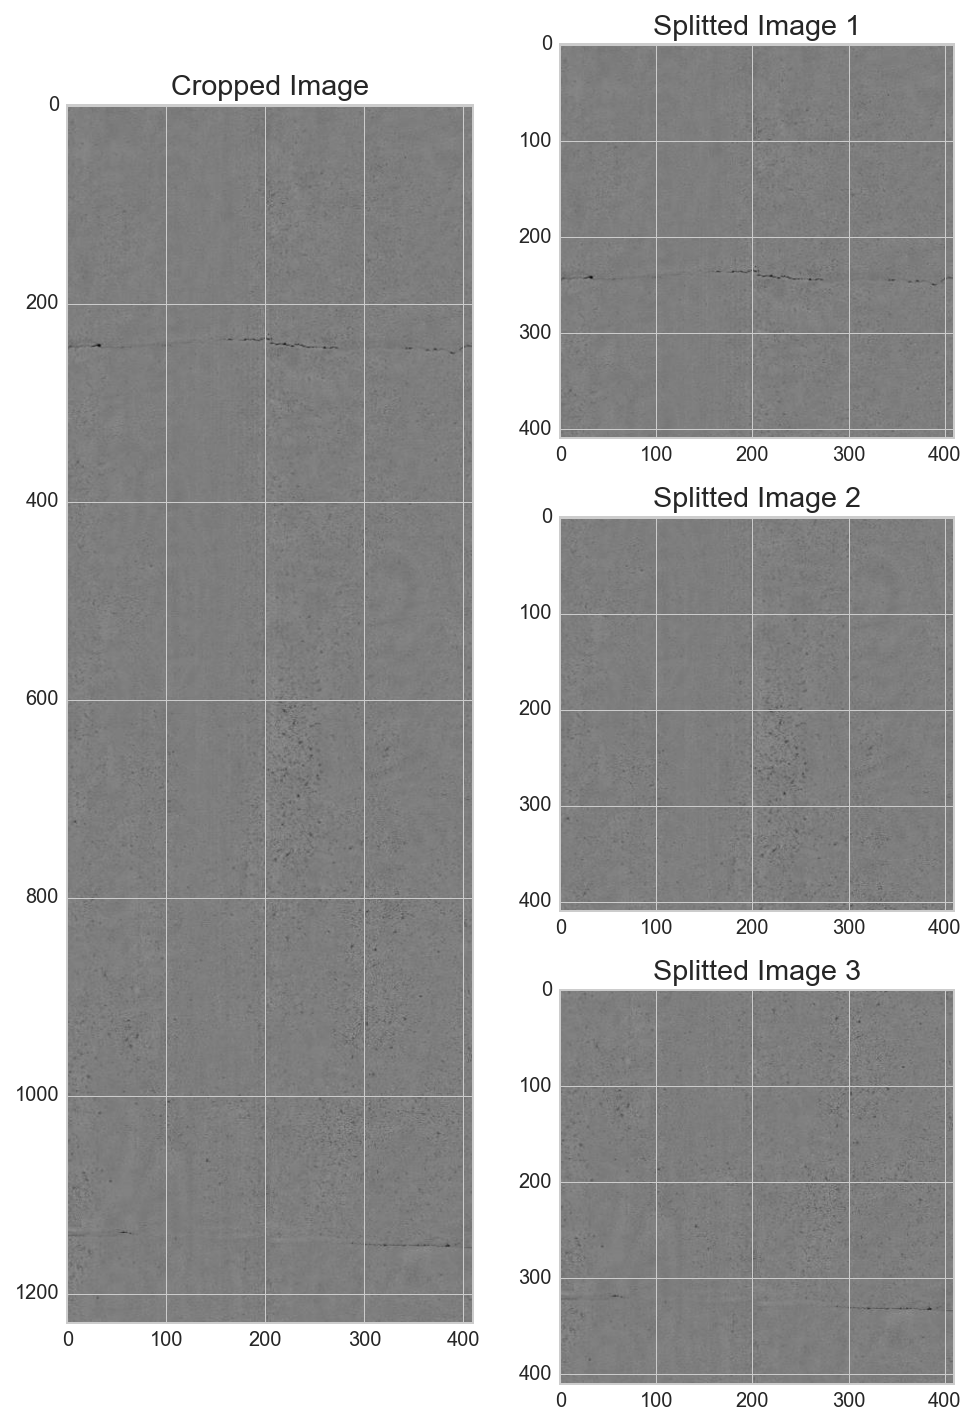

In [14]:
plt.figure(figsize=(8, 12))
plt.subplot(1,2,1)
plt.imshow(images_cropped[0])
plt.title("Cropped Image")
for i in range(1, 4):    
    plt.subplot(3,2,i * 2)
    plt.imshow(images_flatten[i - 1])
    plt.title(f"Splitted Image {i}")
plt.show()

The sequence of the images in `images_flatten` is consistent with the sequence of the labels in `labels_flatten`.

# 2. Preprocess the Images

Multiple each pixel values by 2.5 and reverse it.

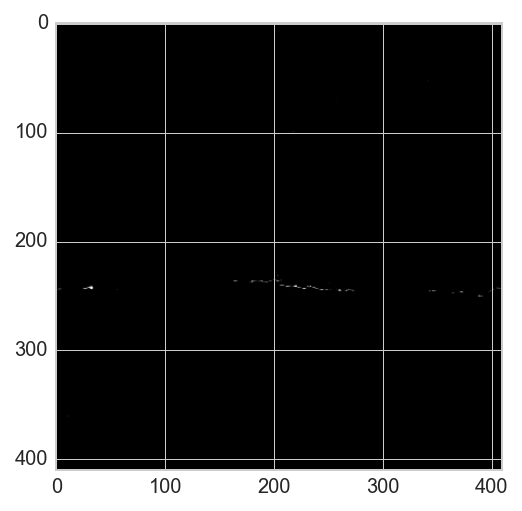

In [15]:
images_flatten_gf = [255 - np.clip(img * 2.5, 0, 255).astype(int) for img in images_flatten]
plt.imshow(images_flatten_gf[0])
plt.show()

Resize it to 224 $\times$ 224 and 299 $\times$ 299 images:

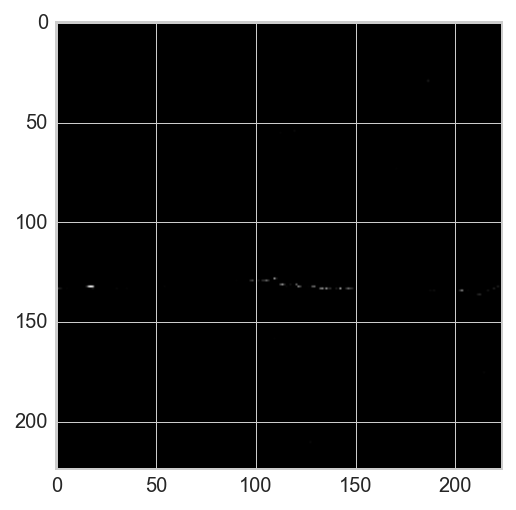

In [16]:
images_flatten_gf_224 = [np.array(Image.fromarray(np.uint8(img)).resize((224,224))).astype(int) for img in images_flatten_gf]
plt.imshow(images_flatten_gf_224[0])
plt.show()

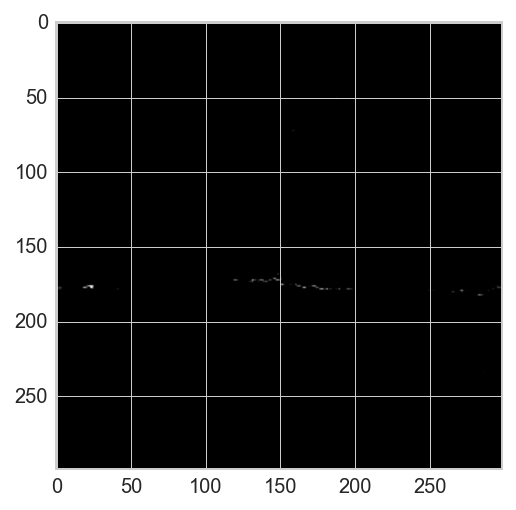

In [17]:
images_flatten_gf_299 = [np.array(Image.fromarray(np.uint8(img)).resize((299,299))).astype(int) for img in images_flatten_gf]
plt.imshow(images_flatten_gf_299[0])
plt.show()

# 3. Use Transfer Learning to Extract Features

## 3.1 VGG16

Load the model:

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# remove the output layer
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

Make prediction:

In [19]:
%%time
# get extracted features for train set
images_vgg = model.predict(np.array(images_flatten_gf_224))
images_vgg.shape

CPU times: user 1min 49s, sys: 1.61 s, total: 1min 51s
Wall time: 1min 44s


(360, 4096)

## 3.2 Xception

Load the model:

In [20]:
# load model
model = tf.keras.applications.Xception()
# remove the output layer
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

Make prediction:

In [21]:
%%time
# get extracted features for train set
images_Xception = model.predict(np.array(images_flatten_gf_299))
images_Xception.shape

CPU times: user 1min 54s, sys: 14.9 s, total: 2min 9s
Wall time: 1min 46s


(360, 2048)

## 3.3 ResNet50

Load the model:

In [22]:
# load model
model = tf.keras.applications.ResNet50()
# remove the output layer
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

Make prediction:

In [23]:
%%time
# get extracted features for train set
images_RN50 = model.predict(np.array(images_flatten_gf_224))
images_RN50.shape

CPU times: user 1min 3s, sys: 2.18 s, total: 1min 5s
Wall time: 42.8 s


(360, 2048)

## 3.4 InceptionV3

Load the model:

In [24]:
# load model
model = tf.keras.applications.InceptionV3()
# remove the output layer
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

Make prediction:

In [25]:
%%time
# get extracted features for train set
images_InceptionV3= model.predict(np.array(images_flatten_gf_299))
images_InceptionV3.shape

CPU times: user 1min 9s, sys: 6.92 s, total: 1min 16s
Wall time: 45.4 s


(360, 2048)

## 3.5 DenseNet121

In [26]:
# load model
model = tf.keras.applications.DenseNet121()
# remove the output layer
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

Make prediction:

In [27]:
%%time
# get extracted features for train set
images_DN121= model.predict(np.array(images_flatten_gf_224))
images_DN121.shape

CPU times: user 58.8 s, sys: 4.02 s, total: 1min 2s
Wall time: 53.5 s


(360, 1024)

## 3.6 Combine All Results Into a Dictionary

In [28]:
images_features = {
    "VGG16": images_vgg,
    "Xception": images_Xception,
    "ResNet50": images_RN50,
    "InceptionV3": images_InceptionV3,
    "DenseNet121": images_DN121
}

# 4. Further Feature Dimension Reduction by PCA

## 4.1 Standardize The Data

In [29]:
from sklearn.preprocessing import StandardScaler

images_features_std = dict()
for model in images_features:
    images_features_std[model] = StandardScaler().fit_transform(images_features[model])

## 4.2 PCA

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

images_features_std_pca = dict()
for model in images_features_std:
    images_features_std_pca[model] = pca.fit_transform(images_features_std[model])

# 5. Train Test Split

We split the 360 samples into a train set of 300 and test set of 60.

In [31]:
images_train_test = dict()
for model in images_features_std_pca:
    features = images_features_std_pca[model]
    x_train, x_test, y_train, y_test = train_test_split(features, labels_flatten["crack_type"], test_size=60, random_state=100)
    images_train_test[model] = {
        "x_train": x_train,
        "x_test": x_test,
        "y_train": y_train,
        "y_test": y_test
    }

# 6. Build FNN Model


In [32]:
%%time
%%capture
def FNN_Model(input_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(5, input_shape=(20, ), activation="relu"))
    model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
    model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.Precision(),
                          tf.keras.metrics.TruePositives()])
    return model

result = dict()

fitted_model = dict()

for model in images_train_test:
    FNN = FNN_Model(20)
    features = images_train_test[model]
    FNN.fit(features["x_train"],features["y_train"].to_numpy(),epochs=1000) 
    val_loss, val_acc, val_pre, val_TP = FNN.evaluate(features["x_test"],features["y_test"].to_numpy())
    result[model] = [val_loss, val_acc, val_pre, val_TP/(features["y_test"] == 1).sum()]
    fitted_model[model] = FNN

CPU times: user 2min 44s, sys: 24.6 s, total: 3min 9s
Wall time: 1min 17s


In [33]:
result = pd.DataFrame(result)
result.index = ["loss", "Accuracy", "Precision", "TPR"]
result

,VGG16,Xception,ResNet50,InceptionV3,DenseNet121
loss,1.164891,1.761322,1.902165,0.661611,0.931008
Accuracy,0.833333,0.700000,0.816667,0.750000,0.800000
Precision,0.842105,0.764706,0.790698,0.800000,0.833333
TPR,0.888889,0.722222,0.944444,0.777778,0.833333


Check this result mannually (Take VGG16 as an example):

In [34]:
fitted = fitted_model["VGG16"]
features = images_train_test["VGG16"]
prediction = fitted.predict_classes(features["x_test"]).reshape(-1,)
prediction

array([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

Distribution of prediction and test set:

In [35]:
np.unique(prediction, return_counts=True)

(array([0, 1], dtype=int32), array([22, 38]))

In [36]:
np.unique(features["y_test"], return_counts=True)

(array([0, 1]), array([24, 36]))

Accuracy:

In [37]:
boolean = prediction == features["y_test"]
boolean.sum() / prediction.shape[0]

0.8333333333333334

Precision:

In [38]:
(prediction[boolean] == 1).sum() / (prediction == 1).sum()

0.8421052631578947

TRP:


In [39]:
(prediction[boolean] == 1).sum() / (features["y_test"] == 1).sum()

0.8888888888888888